<a href="https://colab.research.google.com/github/Karishma-Kuria/ML-Regression/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **MLP, Regression, Latent Manifold on FootBall event dataset.**

### In this colab I have used Various Regression Algorithms to do below prediction:


### 1.   Predict if a shot is goal or no goal.
### 2.   Predict the result of the match



The dataset contains details of 9,074 games, totaling 941,009 events which were played in the biggest 5 European football leagues: Spain, England, Germany, Italy, France from 2011/2012 season to 2016/2017 season as of 25.01.2017. The dataset contains 3 files:

dictionary.txt
events.csv
ginf.csv

In [100]:
# importing relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import linear_model, tree, ensemble
from sklearn.naive_bayes import GaussianNB
import xgboost
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder , MinMaxScaler , LabelEncoder
from sklearn.compose import  ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

### Loading dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
event_path = "/content/drive/MyDrive/ML_DataSet/events.csv"
info_path = "/content/drive/My Drive/ML_DataSet/ginf.csv"
dict_path = "/content/drive/My Drive/ML_DataSet/dictionary.txt"

In [5]:
game_events = pd.read_csv(event_path, engine="python")
game_info = pd.read_csv(info_path, engine="python")
game_info.head(10)

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
5,lOpzwMkp/,/soccer/germany/bundesliga-2011-2012/hertha-be...,True,2011-08-06,D1,2012,germany,Hertha Berlin,Nurnberg,0,1,2.06,3.75,3.95,NaN,NaN,NaN,NaN
6,M7PhlM2C/,/soccer/france/ligue-1-2011-2012/brest-evian-t...,True,2011-08-06,F1,2012,france,Brest,Evian Thonon Gaillard,2,2,2.29,3.25,3.85,NaN,NaN,NaN,NaN
7,QuWqjrYa/,/soccer/france/ligue-1-2011-2012/ac-ajaccio-to...,True,2011-08-06,F1,2012,france,AC Ajaccio,Toulouse,0,2,2.80,3.10,3.05,NaN,NaN,NaN,NaN
8,UBZQ4smg/,/soccer/france/ligue-1-2011-2012/nice-lyon-UBZ...,True,2011-08-06,F1,2012,france,Nice,Lyon,1,3,4.50,3.55,2.00,NaN,NaN,NaN,NaN
9,Wn69eU5B/,/soccer/germany/bundesliga-2011-2012/koln-wolf...,True,2011-08-06,D1,2012,germany,FC Cologne,VfL Wolfsburg,0,3,3.00,3.80,2.54,NaN,NaN,NaN,NaN


In [6]:
# shape of the game info data
game_info.shape

(10112, 18)

In [7]:
# check for unique values
game_info.index.is_unique

True

In [8]:
# check for missing values
game_info.isna().sum()

id_odsp         0
link_odsp       0
adv_stats       0
date            0
league          0
season          0
country         0
ht              0
at              0
fthg            0
ftag            0
odd_h           0
odd_d           0
odd_a           0
odd_over     9135
odd_under    9135
odd_bts      9135
odd_bts_n    9135
dtype: int64

In [9]:
# check the description of numeric variables
game_info.describe()

,season,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
count,10112.000000,10112.000000,10112.000000,10112.000000,10112.000000,10112.000000,977.000000,977.000000,977.000000,977.000000
mean,2014.290249,1.548062,1.154964,2.930120,4.278434,5.537545,2.046817,2.105629,1.942917,2.063941
std,1.610074,1.309591,1.142596,2.370135,1.863643,5.700485,0.367062,0.536646,0.211102,0.251276
min,2012.000000,0.000000,0.000000,1.060000,1.910000,1.110000,1.140000,1.420000,1.410000,1.440000
25%,2013.000000,1.000000,0.000000,1.760000,3.430000,2.740000,1.790000,1.780000,1.800000,1.870000
50%,2014.000000,1.000000,1.000000,2.270000,3.680000,3.860000,2.030000,1.970000,1.920000,2.050000
75%,2016.000000,2.000000,2.000000,3.080000,4.300000,6.000000,2.280000,2.270000,2.050000,2.200000
max,2017.000000,10.000000,9.000000,46.000000,35.000000,81.000000,3.400000,7.500000,3.250000,3.460000


In [11]:
# check for missing data
game_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id_odsp    10112 non-null  object 
 1   link_odsp  10112 non-null  object 
 2   adv_stats  10112 non-null  bool   
 3   date       10112 non-null  object 
 4   league     10112 non-null  object 
 5   season     10112 non-null  int64  
 6   country    10112 non-null  object 
 7   ht         10112 non-null  object 
 8   at         10112 non-null  object 
 9   fthg       10112 non-null  int64  
 10  ftag       10112 non-null  int64  
 11  odd_h      10112 non-null  float64
 12  odd_d      10112 non-null  float64
 13  odd_a      10112 non-null  float64
 14  odd_over   977 non-null    float64
 15  odd_under  977 non-null    float64
 16  odd_bts    977 non-null    float64
 17  odd_bts_n  977 non-null    float64
dtypes: bool(1), float64(7), int64(3), object(7)
memory usage: 1.3+ MB


### **Data Preparation**

### Adding columns such as country/league, date into game_events dataset. 

In [18]:
from datetime import datetime
game_events = game_events.merge(game_info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')
year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
game_events['year'] = [year(x) for key, x in enumerate(game_events['date'])]

### Created a new dataframe which holds all the details of the shots.

In [23]:
game_shots = game_events[game_events.event_type==1]
game_shots['player'] = game_shots['player'].str.title()
game_shots['player2'] = game_shots['player2'].str.title()
game_shots['country'] = game_shots['country'].str.title()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

## **Data Visualization and Predict if the shot is a goal or no goal**

 I have visualized the shots placement by the player in the match.

In [24]:
# collecting data for all kind of short placements in match
graph_bar = game_shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})
graph_bar.shot_place = graph_bar.shot_place.astype(int)
graph_bar.shot_place = graph_bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

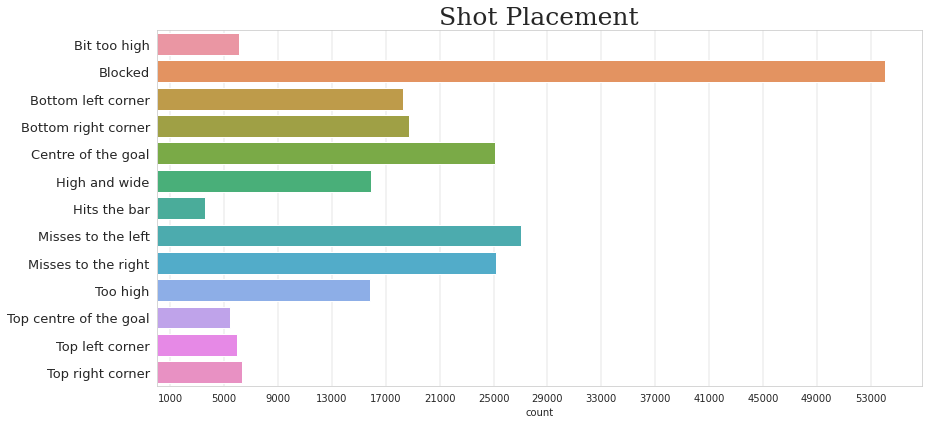

In [25]:
# plot shot placement against their total count 
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = graph_bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=graph_bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

From the above plot we can see that maximum number of shots were blocked by the opponent.
From the part of the shots which were unblocked maximum shots were targeted in the centre and many of the shots were missed to the left and right sides. 

Lets visualise the percentage of shots which got converted into goals for different years in the league.

In [26]:
game_goals  = game_shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})
game_goals.is_goal = game_goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [28]:
game_goals['percentage']=0
for i in range(len(game_goals)):
    for year in game_goals.year.unique():
        if game_goals.iloc[i,game_goals.columns.get_loc("year")]==year:
            game_goals.iloc[i,game_goals.columns.get_loc("percentage")]=game_goals.iloc[i,game_goals.columns.get_loc("count")] / \
                                                            game_goals[game_goals.year==year]['count'].sum()
game_goals['percentage']=round(game_goals['percentage']*100,2)

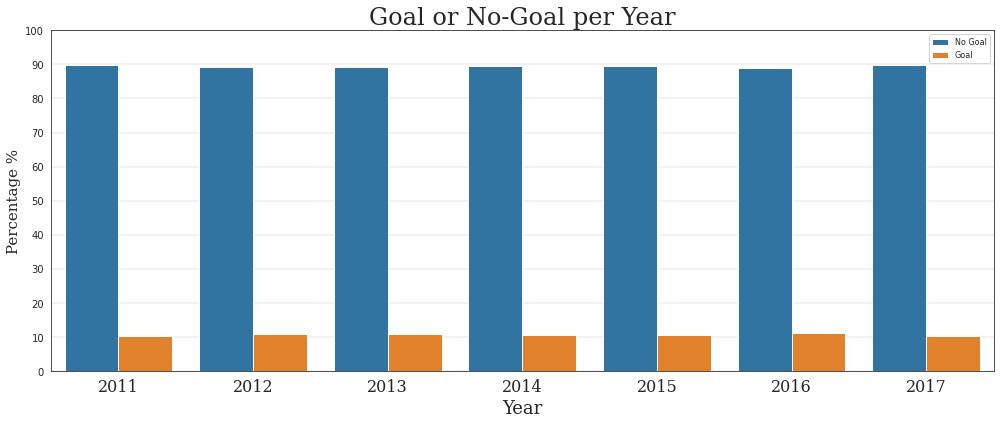

In [31]:
# plot the percentage of goals against year
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=game_goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal or No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=8)
plt.show()

So again from the above graph the percentage of goals is almost same for the mentioned years. So it can be concluded that 1 out of every 9-10 shot is a goal no matter where it was shot.

Now I lets prepare the data for our Expected goal model. This model will evaluate how likely a shot is supposed to turn into a goal. I have divided data into 2 sets:
 For this 

1.   Y: the target variable Y set will include all the shots in the database irrespective of the fact that its a goal or not.
2.   X: It will include all necessary information we have in dataset for shots such as bodypart, location, situation, fast_break.

  

In [32]:
# converting all categorical variable into binary dummies
df = pd.get_dummies(game_shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
df.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
df['is_goal'] = game_shots['is_goal']

In [33]:
print("Total number of shots",len(df))
print("Total number of goals",df.is_goal.sum())

Total number of shots 229135
Total number of goals 24441


### Split dataset into training and testing

In [81]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=1)
x_train

,fast_break,loc_centre_box,loc_diff_angle_lr,diff_angle_left,diff_angle_right,left_side_box,left_side_6ybox,right_side_box,right_side_6ybox,close_range,penalty,outside_box,long_range,more_35y,more_40y,not_recorded,right_foot,left_foot,header,no_assist,assist_pass,assist_cross,assist_header,assist_through_ball,open_play,set_piece,corner,free_kick
536019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
241887,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
848312,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
463302,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0
44032,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213888,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
940932,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
22359,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0
857752,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


### **Gradient Boost Classifier**

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model_result(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(x_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(x_test)),
        'precision': precision_score(y_test, model.predict(x_test)),
        'f1_score': f1_score(y_test, model.predict(x_test)),
        'train_accuracy': model.score(x_train, y_train),
        'test_accuracy': model.score(x_test, y_test),
    }

def objective(params):
    res = evaluate_model_result(params)
    
    res['loss'] = - res['test_ROCAUC'] 
    res['status'] = STATUS_OK 
    return res 

space_hyperparameter = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [42]:
trials_val = Trials()
fmin(
    objective,
    space=space_hyperparameter,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_val
);

100%|██████████| 50/50 [20:32<00:00, 24.65s/it, best loss: -0.8194066987713357]


In [93]:
pd.DataFrame(trials_val.results).sort_values(by='f1_score', ascending=False).head(5)

,learning_rate,min_samples_leaf,max_depth,max_features,train_ROCAUC,test_ROCAUC,recall,precision,f1_score,train_accuracy,test_accuracy,loss,status
28,0.173483,30,18,16,0.819261,0.818101,0.269167,0.710649,0.390448,0.910606,0.910883,-0.818101,ok
42,0.086530,18,7,13,0.818006,0.819062,0.268462,0.713661,0.390156,0.910519,0.911008,-0.819062,ok
20,0.219270,137,8,18,0.818250,0.818946,0.268227,0.714375,0.390015,0.910499,0.911033,-0.818946,ok
19,0.139538,108,6,26,0.818016,0.819101,0.267992,0.715991,0.390006,0.910412,0.911108,-0.819101,ok
40,0.130051,138,7,13,0.817834,0.819407,0.267756,0.715363,0.389664,0.910432,0.911058,-0.819407,ok


From the above table it is clear that with hyperparameter I have got good results. It can also be concluded that there is no sign of overfitting that means the model will work for both test and training data.

### Model Training

In [94]:
GBC_model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 27
                        )
GBC_model.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.285508, max_depth=19,
                           max_features=27, min_samples_leaf=99)

### Check the accuracy of the model

In [96]:
print('Total example in test set {} (shots) of which {} are certainly (goals).'.format(len(y_test), y_test.sum()),'\n')
print('Classifying accuracy of whether a shot is goal or not is {}%.'.format(round(GBC_model.score(x_test, y_test)*100),2),'\n')
print('GBC classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, GBC_model.predict_proba(x_test)[:, 1])*100),2), '\n')

Total example in test set 80198 (shots) of which 8504 are certainly (goals). 

Classifying accuracy of whether a shot is goal or not is 91%. 

GBC classifier obtains an ROC-AUC of 82% 



So I have acheived 91% accuracy of the prediction of correct goals. Also I have got promissing ROC-AUC metric whic is 82%.

### Confusion matrix

In [97]:
con_m=confusion_matrix(y_train,GBC_model.predict(x_train))
con_m=pd.DataFrame(con_m)
con_m.columns=["Predicted No Goals","Predicted Goals"]
con_m.index=["Actual No Goals","Actual Goals"]
print(con_m, '\n')
print(classification_report(y_test,GBC_model.predict(x_test)))

                 Predicted No Goals  Predicted Goals
Actual No Goals              131342             1658
Actual Goals                  11658             4279 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



The confusion matrix is used to analyse the performance of the prediction. The results shows that the model performs much better for predicting if its not a goal.

### **Logistic Regression**

In [90]:
LR_model = LogisticRegression(max_iter=400)
LR_model.fit(x_train, y_train)

LogisticRegression(max_iter=400)

In [98]:
print('Total example in test set {} (shots) of which {} are certainly (goals).'.format(len(y_test), y_test.sum()),'\n')
print('Classifying accuracy of whether a shot is goal or not is {}%.'.format(round(LR_model.score(x_test, y_test)*100),2),'\n')
print('Logistic Regression classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, LR_model.predict_proba(x_test)[:, 1])*100),2),'\n')

Total example in test set 80198 (shots) of which 8504 are certainly (goals). 

Classifying accuracy of whether a shot is goal or not is 91%. 

Logistic Regression classifier obtains an ROC-AUC of 82% 



In [99]:
con_m=confusion_matrix(y_train,LR_model.predict(x_train))
con_m=pd.DataFrame(con_m)
con_m.columns=["Predicted No Goals","Predicted Goals"]
con_m.index=["Actual No Goals","Actual Goals"]
print(con_m, '\n')
print(classification_report(y_test,LR_model.predict(x_test)))

                 Predicted No Goals  Predicted Goals
Actual No Goals              131414             1586
Actual Goals                  11785             4152 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



We get almost same result as Gradient Boost.

### **Lets predict the result of the match using data from game_info dataset.**

### Column: Odd

Odds refers to the amount which one recieves when we bet 1 unit on the result. For instance, suppose the odds for a away win is 4, than the one who has bet on away win will get 4 unit per 1 unit.

In [43]:
# function to predict odds
def pred_odds_result(odd_home,odd_draw,odd_away):
    if odd_home<odd_draw and odd_home<odd_draw:
        return("Home Win")
    elif odd_draw<odd_home and odd_draw<odd_away:
        return("Draw")
    elif odd_away<odd_draw and odd_away<odd_home:
        return("Away Win")

In [45]:
# function returns actual result of match
def actual_result(fthg,ftag):
    if fthg>ftag:
        return("Home Win")
    elif fthg==ftag:
        return("Draw")
    elif fthg<ftag:
        return("Away Win")
    
def actual_result_encoder(fthg,ftag):
    if fthg>ftag:
        return (1)
    elif fthg==ftag:
        return (2)
    elif fthg<ftag:
        return (3)

In [46]:
# compare chances of correct prediction by looking into the odds
def compare_pred(data):
    correct=0
    wrong=0
    for i in range(1,data.shape[0]+1):
        odd_home=data[i-1:i]["odd_h"].item()
        odd_draw=data[i-1:i]["odd_d"].item()
        odd_away=data[i-1:i]["odd_a"].item()
        fthg=data[i-1:i]["fthg"].item()
        ftag=data[i-1:i]["ftag"].item()
        odds_result=pred_odds_result(odd_home,odd_draw,odd_away)
        actresult=actual_result(fthg,ftag)
        if odds_result==actresult:
            correct+=1
        else:
            wrong+=1
    return(str("%.2f"%(correct/(correct+wrong)))+str("% correct"))

In [47]:
compare_pred(game_info)

'0.53% correct'

The above percentage shows that guessing the result based on the odds, would be right half of the time. So we want better indicator to improve this.

### Predicting results

Lets try using the difference among the odds and odds for predicting the result of a match.

In [48]:
x = game_info.iloc[:,9:14]
x.head()

,fthg,ftag,odd_h,odd_d,odd_a
0,3,1,1.56,4.41,7.42
1,2,2,2.36,3.60,3.40
2,2,0,1.83,4.20,4.80
3,0,1,1.55,4.50,9.40
4,1,0,2.50,3.40,3.45


In [49]:
x=game_info.iloc[:,9:14]
result=[]
for i in range(1,game_info.shape[0]+1):
    result.append(actual_result_encoder(game_info[i-1:i]["fthg"].item(),game_info[i-1:i]["ftag"].item()))
y=pd.DataFrame(result)
x["diff_h_d"]=abs(x["odd_h"]-x["odd_d"])
x["diff_d_a"]=abs(x["odd_d"]-x["odd_a"])
x["diff_h_a"]=abs(x["odd_h"]-x["odd_a"])
x=x.drop(["fthg","ftag"],axis=1)
x.tail()

,odd_h,odd_d,odd_a,diff_h_d,diff_d_a,diff_h_a
10107,1.97,4.35,8.0,2.38,3.65,6.03
10108,1.19,8.50,20.0,7.31,11.50,18.81
10109,1.32,6.24,11.5,4.92,5.26,10.18
10110,1.74,4.07,5.9,2.33,1.83,4.16
10111,1.79,3.96,5.4,2.17,1.44,3.61




1.   Split data into training set and test set
2.   Apply cross validation



In [50]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [51]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

Function to check the accuracy of the models.

In [57]:
def check_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))

from sklearn.metrics import accuracy_score
def normalized_score(model):
    return (accuracy_score(y_train,model.predict(x_train)))

Function to print the confusion matrix for each model.

In [63]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_model_val(model_used):
    cm=confusion_matrix(y_train,model_used.predict(x_train))
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Home Win","Predicted Draw","Predicted Away Win"]
    cm.index=["Actual Home Win","Actual Draw","Actual Away Win"]
    return cm

### Logistic Regression

In [64]:
logistic_reg=LogisticRegression()
logistic_reg.fit(x_train,y_train)
print("Logistic Regression Accuracy (without cross validation): "+str(normalized_score(logistic_reg)))
print("Logistic Regression Cross Validation Accuracy: "+str(check_score(logistic_reg)))
confusion_matrix_model_val(logistic_reg)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

Logistic Regression Accuracy (without cross validation): 0.5277537396464335


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

Logistic Regression Cross Validation Accuracy: 0.5270123242237698


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3234,4,486
Actual Draw,1544,0,510
Actual Away Win,1275,1,1035


### Decision Tree Regression

In [65]:
Decision_tree=DecisionTreeClassifier()
Decision_tree.fit(x_train,y_train)
print("Decision Tree Regression Accuracy (without cross validation): "+str(normalized_score(Decision_tree)))
print("Decision Tree Regression Cross Validation Accuracy: "+str(check_score(Decision_tree)))
confusion_matrix_model_val(Decision_tree)

Decision Tree Regression Accuracy (without cross validation): 0.9749041908764989
Decision Tree Regression Cross Validation Accuracy: 0.4278659633577697


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3722,2,0
Actual Draw,89,1965,0
Actual Away Win,63,49,2199


### K-Nearest Neighbour Regression

In [67]:
KNN_model=KNeighborsClassifier(n_neighbors=20)
KNN_model.fit(x_train,y_train)
print("KNN Regression Accuracy (without cross validation): "+str(normalized_score(KNN_model)))
print("KNN Regression Cross Validation Accuracy: "+str(check_score(KNN_model)))
confusion_matrix_model_val(KNN_model)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Regression Accuracy (without cross validation): 0.5617505254048708


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

KNN Regression Cross Validation Accuracy: 0.5064905640749489


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3030,259,435
Actual Draw,1185,432,437
Actual Away Win,981,248,1082


### Support Vector Machine

In [69]:
from sklearn.svm import SVC, LinearSVC
from sklearn import svm

In [72]:
svm_reg_model=svm.SVC()
svm_reg_model.fit(x_train,y_train)
print("SVM Regression Accuracy (without cross validation): "+str(normalized_score(svm_reg_model)))
print("SVM Regression Cross Validation Accuracy: "+str(check_score(svm_reg_model)))
confusion_matrix_model_val(svm_reg_model)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Regression Accuracy (without cross validation): 0.5262702435406107


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

SVM Regression Cross Validation Accuracy: 0.5260249788884945


,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,3352,0,372
Actual Draw,1660,0,394
Actual Away Win,1406,0,905


### Multinomial Naive Bayes

In [71]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes_model=MultinomialNB()
naive_bayes_model.fit(x_train,y_train)
print("Multinomial Naive Bayes Regression Accuracy (without cross validation): "+str(normalized_score(naive_bayes_model)))
print("Multinomial Naive Bayes Regression Cross Validation Accuracy: "+str(check_score(naive_bayes_model)))
confusion_matrix_model_val(naive_bayes_model)

Multinomial Naive Bayes Regression Accuracy (without cross validation): 0.49091358635183585
Multinomial Naive Bayes Regression Cross Validation Accuracy: 0.49066336021735674


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

,Predicted Home Win,Predicted Draw,Predicted Away Win
Actual Home Win,2060,895,769
Actual Draw,686,601,767
Actual Away Win,472,529,1310
